In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from credit_g_dataset import get_preprocessed_credit_g_dataset

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 6)

# Load version 3 of the dataset credit-g

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
     duration  credit_amount  installment_commitment  residence_since  age  \
0          18         3049.0                       1                1   45   
1          24         1927.0                       3                2   33   
2          12          640.0                       4                2   49   
..        ...            ...                     ...              ...  ...   
997        15         1275.0                       4                2   24   
998        18         1808.0                       4                1   22   
999        60         6836.0                       3                4   63   

     existing_credits  num_dependents checking_status  \
0                   1               1           >=200   
1                   2               1     no checking   
2                   1               1     no checking   
..                ...             ...             ...   
997             

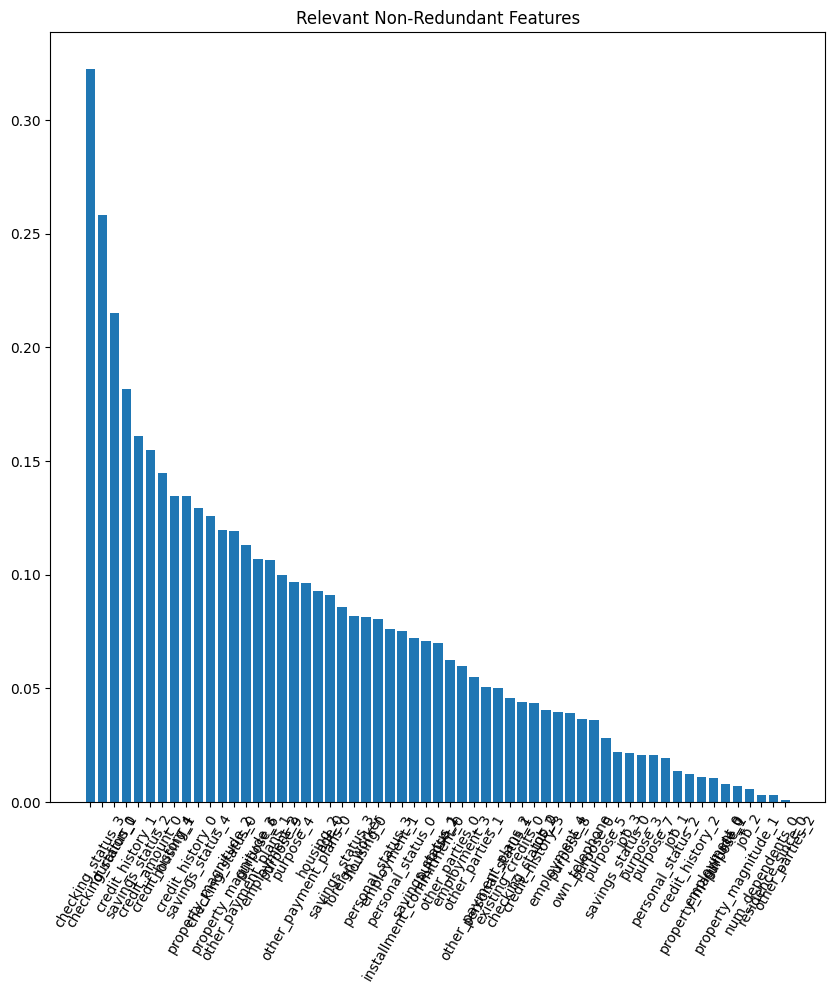

X_train type:  <class 'pandas.core.frame.DataFrame'>
X_train Shape:  (900, 59)
y_train type:  <class 'numpy.ndarray'>
y_train Shape:  (900,)


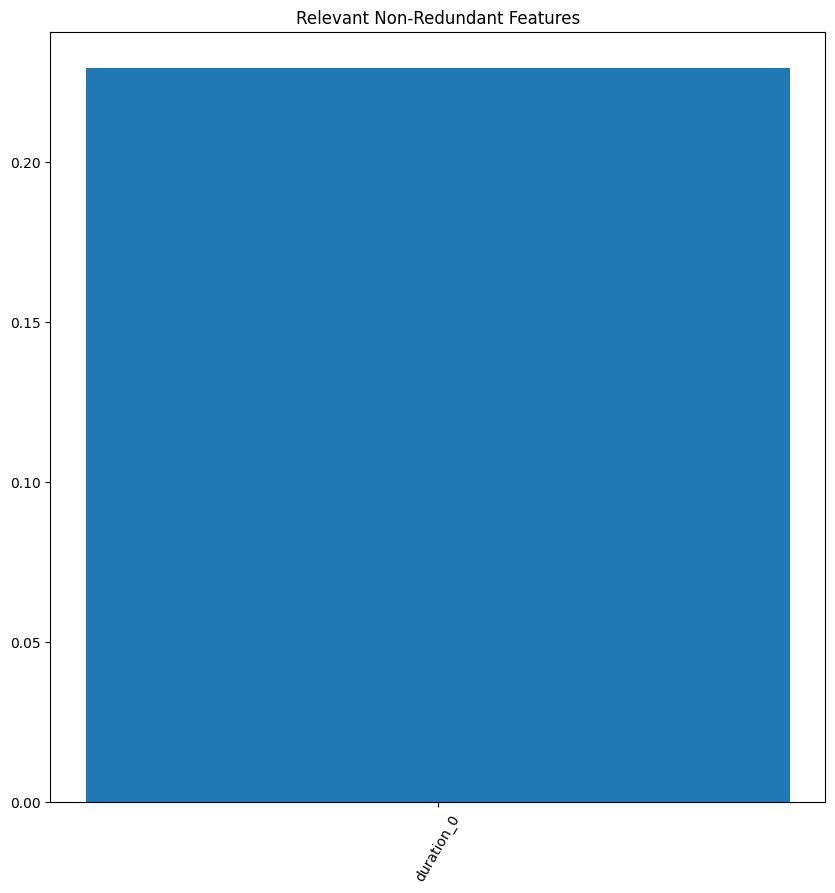

Total Nr. of numeric Features:  7
Nr. of selected numeric Features:  1
Relevant and non-redundant numerical features: ['duration_0']


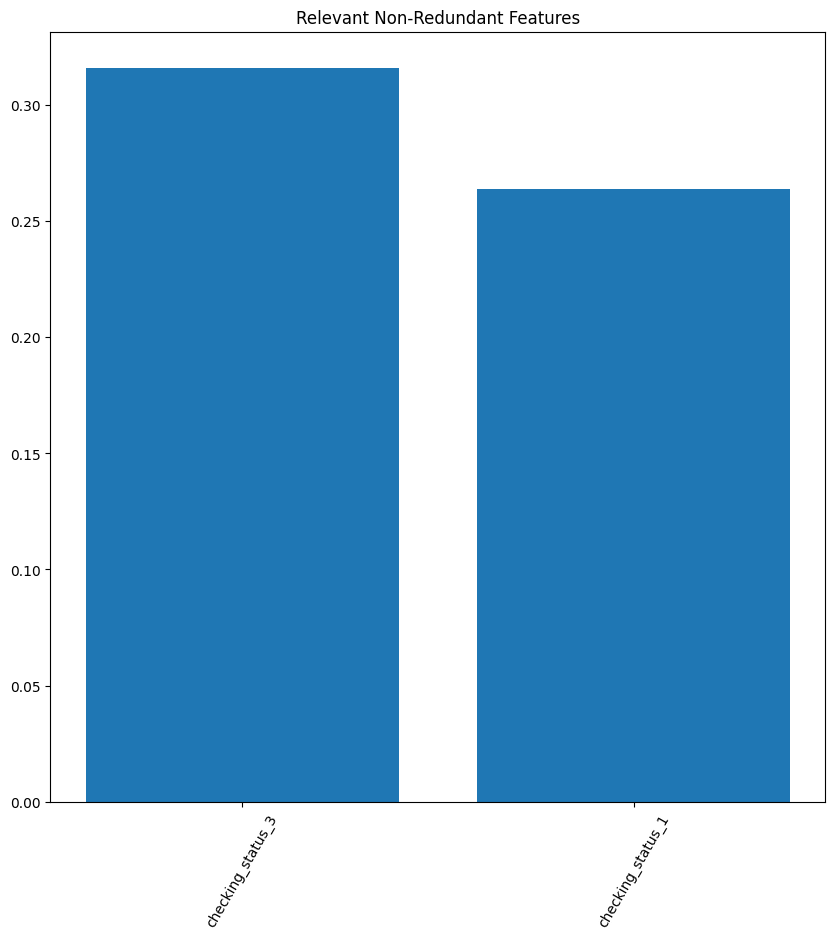

Total Nr. of categorical features:  52
Nr. of selected categorical Features:  2
Relevant and non-redundant categorical features: ['duration_0']
All selected features: ['duration_0', 'checking_status_3', 'checking_status_1']

Training Set

X_train type:  <class 'pandas.core.frame.DataFrame'>
X_train Shape:  (630, 3)
Y_train type:  <class 'numpy.ndarray'>
Y_train Shape:  (630,)


Validation Set

X_validation type:  <class 'pandas.core.frame.DataFrame'>
X_validation Shape:  (270, 3)
Y_validation type:  <class 'numpy.ndarray'>
Y_validation Shape:  (270,)


Test Set

X_test_lowdim type:  <class 'pandas.core.frame.DataFrame'>
X_test_lowdim Shape:  (100, 3)
Y_test type:  <class 'numpy.ndarray'>
Y_test Shape:  (100,)


In [2]:
#%%capture
X_train, X_validation, X_test, y_train, y_validation, y_test = get_preprocessed_credit_g_dataset()

## Train the model on the training set and adjust hyperparameters on the validation set

In [3]:
n_estimators = [10, 50, 100, 250, 500]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,10,15]
min_samples_split = [2,5,10,15]
min_samples_leaf = [1,2,5,10]

random_state = 42

best_mcc = 0
best_acc = 0
best_recall = 0
best_precision = 0
best_specificity = 0
best_n_estimators = 0
best_criterion = ""
best_max_depth = 0
best_min_split = 0
best_min_leaf = 0

iter_n = 0
for n in n_estimators:
    for c in criterion:
        for md in max_depth:
            for min_split in min_samples_split:
                for min_leaf in min_samples_leaf:

                    model = RandomForestClassifier(n_estimators=n, criterion=c,max_depth=md, min_samples_split=min_split, min_samples_leaf=min_leaf, random_state=random_state)
                    model.fit(X_train, y_train)
                    y_predicted = model.predict(X_validation)
                    (tn, fp, fn, tp) = confusion_matrix(y_validation, y_predicted).ravel()

                    precision_val = float(tp)/float(tp+fp)
                    recall_val = float(tp)/float(tp+fn)
                    specificity_val = float(tn)/float(tn+fp)
                    accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
                    f1_val = (2*tp)/(2*tp+fp+fn)
                    mcc_val = float((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

                    iter_n += 1

                    #print(iter_n)
                    
                    if mcc_val > best_mcc:
                        best_mcc = mcc_val
                        best_acc = accuracy_val
                        best_recall = recall_val
                        best_precision = precision_val
                        best_specificity = specificity_val

                        best_n_estimators = n
                        best_criterion = c
                        best_max_depth = md
                        best_min_split = min_split
                        best_min_leaf = min_leaf
                    
                        print("mcc_val =", mcc_val)
                        print("accuracy_val =", accuracy_val)

mcc_val = 0.18175730357363373
accuracy_val = 0.6925925925925925
mcc_val = 0.19930840835229455
accuracy_val = 0.7
mcc_val = 0.20336634117954808
accuracy_val = 0.6962962962962963
mcc_val = 0.21360453144631172
accuracy_val = 0.7037037037037037
mcc_val = 0.21973388950268985
accuracy_val = 0.7037037037037037
mcc_val = 0.23316080506381553
accuracy_val = 0.7074074074074074


In [4]:
print("\n")
print("best validation precision_val =", precision_val)
print("best validation recall_val =", recall_val)
print("best validation pecificity =", specificity_val)
print("best validation mcc_val =", mcc_val)
print("best validation accuracy_val =", accuracy_val)
print("best_n_estimators =", best_n_estimators)
print("best_criterion =", best_criterion)
print("best_max_depth =", best_max_depth)
print("best_min_split =", best_min_split)
print("best_min_leaf =", best_min_leaf)
print("\n\n") 



best validation precision_val = 0.7167381974248928
best validation recall_val = 0.907608695652174
best validation pecificity = 0.23255813953488372
best validation mcc_val = 0.1898998327053899
best validation accuracy_val = 0.6925925925925925
best_n_estimators = 10
best_criterion = entropy
best_max_depth = 10
best_min_split = 15
best_min_leaf = 1





## Run on the test set and use training and validation sets for training

In [5]:
X_train_val = np.concatenate((X_train, X_validation))
y_train_val = np.concatenate((y_train, y_validation))

model = RandomForestClassifier(n_estimators=best_n_estimators, criterion=best_criterion,max_depth=best_max_depth, min_samples_split=best_min_split, min_samples_leaf=best_min_leaf, random_state=random_state)
model.fit(X_train_val, y_train_val)

(tn, fp, fn, tp) = confusion_matrix(y_validation, y_predicted).ravel()

precision_val = float(tp)/float(tp+fp)
recall_val = float(tp)/float(tp+fn)
specificity_val = float(tn)/float(tn+fp)
accuracy_val = float(tp+tn)/float(tn+fp+fn+tp)
f1_val = (2*tp)/(2*tp+fp+fn)
mcc_val = float((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))

In [6]:
print("\n")
print("Test set precision_val =", precision_val)
print("Test set recall_val =", recall_val)
print("Test set pecificity =", specificity_val)
print("Test set mcc_val =", mcc_val)
print("Test set accuracy_val =", accuracy_val)
print("Test set f1_val =", f1_val)



Test set precision_val = 0.7167381974248928
Test set recall_val = 0.907608695652174
Test set pecificity = 0.23255813953488372
Test set mcc_val = 0.1898998327053899
Test set accuracy_val = 0.6925925925925925
Test set f1_val = 0.8009592326139089
